In [1]:
#import os

# args.output_attention = True

#exp = Exp(args)

#model = exp.model

#setting = 'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
#path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
#model.load_state_dict(torch.load(path))

In [2]:
import torch
import os
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

os.environ["CUDA_VISIBLE_DEVICES"] = '0' #disable CUDA by setting CUDA_VISIBLE_DEVICES to an empty string 


True
1
NVIDIA GeForce GTX 1660 Ti
0


In [3]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')


# DLinear
parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

# args = parser.parse_args()
args = dotdict()

# basic config
args.is_training = 1
args.model_id = 'test'
args.model = 'Autoformer' #Autoformer/Informer/Transformer/DLinear/NLinear

# data loader
args.data = 'ETTh1'
args.root_path = './dataset/ETT-small/'
args.data_path ='ETTh1.csv' 
args.features = 'M'
args.target = 'OT'
args.freq = 'h'
args.checkpoints = './checkpoints/'

# forecasting task
args.seq_len = 96
args.label_len = 48
args.pred_len = 96

# DLinear
args.individual = False

# Formers 
args.embed_type = 0
args.enc_in = 7
args.dec_in = 7
args.c_out = 7
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.dropout = 0.05
args.embed = 'timeF'
args.do_predict = True

# optimization
args.num_workers = 10
args.itr = 1
args.train_epochs = 10
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32 
args.lradj = 'type1'

# GPU
args.gpu = 0
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False

print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'is_training': 1, 'model_id': 'test', 'model': 'DLinear', 'data': 'ETTh1', 'root_path': './dataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './checkpoints/', 'seq_len': 96, 'label_len': 48, 'pred_len': 96, 'individual': False, 'embed_type': 0, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'moving_avg': 25, 'factor': 1, 'distil': True, 'dropout': 0.05, 'embed': 'timeF', 'do_predict': True, 'num_workers': 10, 'itr': 1, 'train_epochs': 10, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'lradj': 'type1', 'gpu': 0, 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False}


In [4]:
if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        if args.do_predict:
            print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.predict(setting, True)

        torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : test_DLinear_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8449
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.7157342
	speed: 0.2530s/iter; left time: 642.9595s
	iters: 200, epoch: 1 | loss: 0.4228222
	speed: 0.0031s/iter; left time: 7.6199s
Epoch: 1 cost time: 26.630770444869995
Epoch: 1, Steps: 264 | Train Loss: 0.6620889 Vali Loss: 0.8593202 Test Loss: 0.5310578
Validation loss decreased (inf --> 0.859320).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.4201811
	speed: 0.7632s/iter; left time: 1737.9055s
	iters: 200, epoch: 2 | loss: 0.3767448
	speed: 0.0027s/iter; left time: 5.8404s
Epoch: 2 cost time: 25.685635328292847
Epoch: 2, Steps: 264 | Train Loss: 0.4363616 Vali Loss: 0.7708485 Test Loss: 0.4540242
Validation loss decreased (0.859320 --> 0.770849).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.4468

In [5]:
exp.args.root_path = './dataset/ETT-small/'
exp.args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

NameError: name 'pd' is not defined

In [6]:
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)
torch.cuda.empty_cache()

>>>>>>>predicting : test_DLinear_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


torch.Size([1, 7, 96])
torch.Size([96])


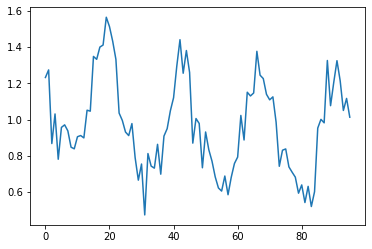

torch.Size([96])


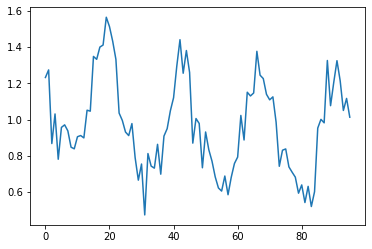

torch.Size([96])


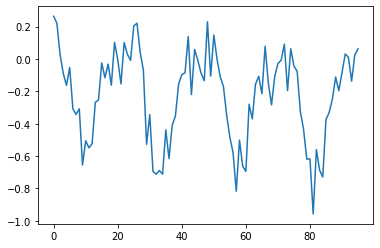

FileNotFoundError: [Errno 2] No such file or directory: './results/test_DLinear_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0/true.npy'

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
# data_pred = np.load('./results/test_Autoformer_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0/pred.npy')
data_pred = np.load('./results/test_DLinear_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0/real_prediction.npy')
data_pred = torch.from_numpy(data_pred).permute(0,2,1)

plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])#没问题
print(data_pred[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_pred[0,0,:])#没问题
print(data_pred[-1,-1,:].shape)
plt.show()
'''
Ground Truth
'''
data_gt = np.load('./results/test_DLinear_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_None_0/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0,2,1)

#预测OT
plt.plot(data_gt[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])#没问题
print(data_gt[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_gt[0,0,:])#没问题
print(data_gt[-1,-1,:].shape)
plt.show()

